In [4]:
# Load csv as pandas dataframe
import pandas as pd


In [5]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# Set headers to mimic a browser request
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:91.0) Gecko/20100101 Firefox/91.0',
    'Accept-Language': 'en-US,en;q=0.5',
    'Accept-Encoding': 'gzip, deflate, br',
    'Connection': 'keep-alive',
    'Upgrade-Insecure-Requests': '1',
    'DNT': '1',  # Do Not Track request header
}

# Function to extract tables from a given URL
def extract_table_from_url(url, required_columns, headers):
    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.text, 'html.parser')
    
    # Find all tables with the target class
    tables = soup.find_all('table', class_='BlogTableTiling MyTable')
    
    print(f"Found {len(tables)} tables on {url}")
    
    tablesdf_combined = pd.DataFrame()  # Initialize empty DataFrame for all tables
    i = 0  # Counter to track number of matching tables
    
    # Iterate over found tables
    for table in tables:
        # Get the first row (headers)
        headers_row = table.find_all('tr')[0]
        headers = [td.get_text(strip=True) for td in headers_row.find_all('td')]
        
        # Normalize and remove extra spaces
        headers = [header.replace('\n', ' ').strip() for header in headers]

        # print(f"Extracted headers: {headers}")
        
        # Check if headers match the required columns
        if headers == required_columns:
            print(f"Found matching table {i + 1} on {url}")
            i += 1
            
            # If headers match, convert the table to a pandas DataFrame
            rows = []
            for row in table.find_all('tr')[1:]:
                row_data = []
                for idx, td in enumerate(row.find_all('td')):
                    # Check if it's the "BullishBearish" column (assuming it's the 3rd column based on the example)
                    if idx == 2:
                        bgcolor = td.get('bgcolor', '').lower()  # Get the background color and normalize case
                        if bgcolor == '#ff0000':
                            row_data.append(-1)  # Red color, mark as -1
                        elif bgcolor == '#008000':
                            row_data.append(1)  # Green color, mark as 1
                        else:
                            row_data.append(0)  # No color or other color, mark as 0 (or leave as is)
                    else:
                        row_data.append(td.get_text(strip=True))  # For all other columns
                rows.append(row_data)

            tabledf = pd.DataFrame(rows, columns=headers)
            
            # Concatenate the current DataFrame with the previously combined ones
            tablesdf_combined = pd.concat([tablesdf_combined, tabledf], ignore_index=True)
            
            # print(f"Table {i} extracted: \n{tabledf.head()}")  # Print the first few rows of the extracted table
            
    return tablesdf_combined




# Function to loop through months and years, extracting the required table
def scrape_tables(start_year, end_year, required_columns, headers):
    df_list = []
    months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

    for year in range(start_year, end_year + 1):
        for month in months:
            url = f"https://thepatternsite.com/Blog-{month}{str(year)[-2:]}.html"
            print(f"Scraping {url}")

            # Extract table from the URL
            table_df = extract_table_from_url(url, required_columns, headers)
            
            if table_df is not None:
                df_list.append(table_df)
            else:
                print(f"No matching table found for {url}")
    
    # Concatenate all DataFrames into one
    if df_list:
        final_df = pd.concat(df_list, ignore_index=True)
        return final_df
    else:
        return pd.DataFrame()  # Return empty DataFrame if no tables were found

# Define the required columns for the table
required_columns = ['Symbol', 'Chart Pattern', 'BullishBearish', 'Start', 'End', 'Industry']

# Scrape tables from the blog pages between 2020 and 2024
final_data = scrape_tables(2020, 2024, required_columns, headers)

# Save the final DataFrame to a CSV file
final_data.to_csv('Datasets/scraped_blog_tables.csv', index=False)
print("Tables successfully scraped and saved to 'scraped_blog_tables.csv'")

# extract_table_from_url("https://thepatternsite.com/Blog-Jan20.html", required_columns, headers)


Scraping https://thepatternsite.com/Blog-Jan20.html
Found 23 tables on https://thepatternsite.com/Blog-Jan20.html
Found matching table 1 on https://thepatternsite.com/Blog-Jan20.html
Found matching table 2 on https://thepatternsite.com/Blog-Jan20.html
Found matching table 3 on https://thepatternsite.com/Blog-Jan20.html
Found matching table 4 on https://thepatternsite.com/Blog-Jan20.html
Scraping https://thepatternsite.com/Blog-Feb20.html
Found 22 tables on https://thepatternsite.com/Blog-Feb20.html
Found matching table 1 on https://thepatternsite.com/Blog-Feb20.html
Found matching table 2 on https://thepatternsite.com/Blog-Feb20.html
Found matching table 3 on https://thepatternsite.com/Blog-Feb20.html
Found matching table 4 on https://thepatternsite.com/Blog-Feb20.html
Scraping https://thepatternsite.com/Blog-Mar20.html
Found 33 tables on https://thepatternsite.com/Blog-Mar20.html
Found matching table 1 on https://thepatternsite.com/Blog-Mar20.html
Found matching table 2 on https://the

In [6]:
final_data

Symbol                Chart Pattern  BullishBearish       Start  \
0        ACN        Triangle, symmetrical               1  12/19/2019   
1        ADS               Broadening top              -1  12/13/2019   
2        AVY                Triple bottom               1  12/03/2019   
3       CMTL              Dead-cat bounce              -1  01/29/2020   
4       CSOD                     Pipe top              -1  01/13/2020   
...      ...                          ...             ...         ...   
10042     SO       Head-and-shoulders top               0  09/05/2024   
10043   SRDX                 Rising wedge               0  10/25/2024   
10044   TDOC    Double Top, Adam and Adam               0  11/25/2024   
10045    TER  Double Bottom, Adam and Eve               0  11/05/2024   
10046   TEVA  Double Bottom, Adam and Eve               0  11/15/2024   

              End                  Industry  
0      01/30/2020               IT Services  
1      01/24/2020      Information Services  
2      01/27/2020   Packaging and Container  
3      01/29/2020        Telecom. Equipment  
4      01/21/2020                E-Commerce  
...           ...                       ...  
10042  11/27/2024   Electric Utility (East)  
10043  12/05/2024          Medical Supplies  
10044  12/02/2024    Healthcare Information  
10045  11/20/2024  Semiconductor Cap Equip.  
10046  11/29/2024                      Drug  

[10047 rows x 6 columns]

In [7]:


# Load csv as pandas dataframe
# cleanedPatternDf = pd.read_csv('Extracted Cleaned data of 2019 - 2024 chart patterns by Mr. Bulkowski.csv')
cleanedPatternDf = pd.read_csv('Datasets/scraped_blog_tables.csv')
cleanedPatternDf

Symbol                Chart Pattern  BullishBearish       Start  \
0        ACN        Triangle, symmetrical               1  12/19/2019   
1        ADS               Broadening top              -1  12/13/2019   
2        AVY                Triple bottom               1  12/03/2019   
3       CMTL              Dead-cat bounce              -1  01/29/2020   
4       CSOD                     Pipe top              -1  01/13/2020   
...      ...                          ...             ...         ...   
10042     SO       Head-and-shoulders top               0  09/05/2024   
10043   SRDX                 Rising wedge               0  10/25/2024   
10044   TDOC    Double Top, Adam and Adam               0  11/25/2024   
10045    TER  Double Bottom, Adam and Eve               0  11/05/2024   
10046   TEVA  Double Bottom, Adam and Eve               0  11/15/2024   

              End                  Industry  
0      01/30/2020               IT Services  
1      01/24/2020      Information Services  
2      01/27/2020   Packaging and Container  
3      01/29/2020        Telecom. Equipment  
4      01/21/2020                E-Commerce  
...           ...                       ...  
10042  11/27/2024   Electric Utility (East)  
10043  12/05/2024          Medical Supplies  
10044  12/02/2024    Healthcare Information  
10045  11/20/2024  Semiconductor Cap Equip.  
10046  11/29/2024                      Drug  

[10047 rows x 6 columns]

In [8]:
# create a new df with the xolumn number of days from start to end of the pattern
patternDf = cleanedPatternDf.copy()
patternDf['Start'] = pd.to_datetime(patternDf['Start'])
patternDf['End'] = pd.to_datetime(patternDf['End'])
patternDf['Days'] = (patternDf['End'] - patternDf['Start']).dt.days
patternDf.head()


Symbol          Chart Pattern  BullishBearish      Start        End  \
0    ACN  Triangle, symmetrical               1 2019-12-19 2020-01-30   
1    ADS         Broadening top              -1 2019-12-13 2020-01-24   
2    AVY          Triple bottom               1 2019-12-03 2020-01-27   
3   CMTL        Dead-cat bounce              -1 2020-01-29 2020-01-29   
4   CSOD               Pipe top              -1 2020-01-13 2020-01-21   

                  Industry  Days  
0              IT Services    42  
1     Information Services    42  
2  Packaging and Container    55  
3       Telecom. Equipment     0  
4               E-Commerce     8

In [9]:
# get the min max and mean of the days
minDays = patternDf['Days'].min()
print("Min Days: ", minDays)

maxDaysDays = patternDf['Days'].max()
print("Max Days: ", maxDaysDays)

meanDays = patternDf['Days'].mean()
print("Mean Days: ", meanDays)

Min Days:  0
Max Days:  311
Mean Days:  22.472180750472777


In [10]:
# number of rows in the dataframe
numRows = len(patternDf)
print("Number of rows: ", numRows)

Number of rows:  10047


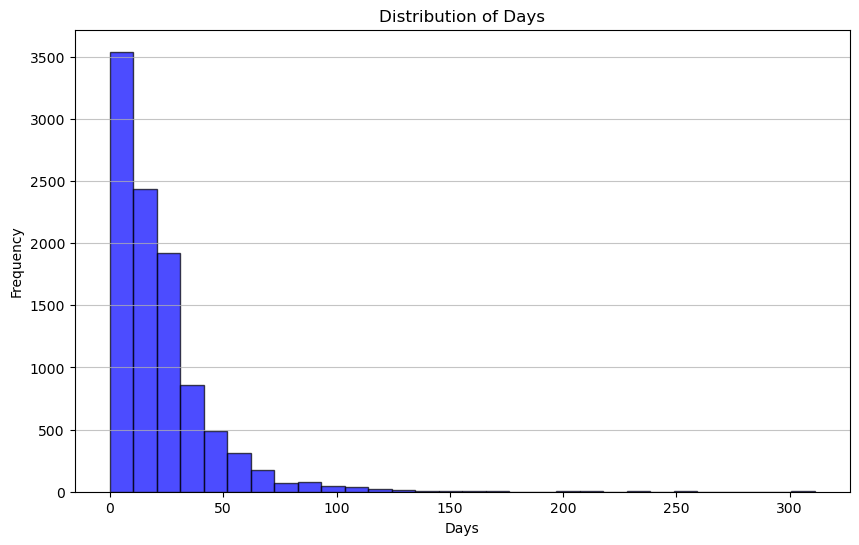

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have loaded your DataFrame as patternDf
# patternDf = pd.read_csv('your_data.csv') # Example of loading data if needed

# Plot a histogram to visualize the distribution of 'Days' data
plt.figure(figsize=(10, 6))
plt.hist(patternDf['Days'], bins=30, color='blue', alpha=0.7, edgecolor='black')
plt.title('Distribution of Days')
plt.xlabel('Days')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

plt.show()


In [12]:
# get the number of occurances of each values in the Symbol column
numberofTimes=cleanedPatternDf['Symbol'].value_counts()
numberofTimes

Symbol
HOV     41
AA      37
AMWD    36
CENX    36
WLK     33
        ..
XLP      1
XLE      1
XLV      1
XHB      1
BZH      1
Name: count, Length: 673, dtype: int64

In [13]:
#  get all the unique values in the Chart Pattern column 
uniquePatterns=cleanedPatternDf['Chart Pattern'].value_counts()
uniquePatterns.head(30)

Chart Pattern
Pipe bottom                     1462
Double Bottom, Adam and Adam     657
Pipe top                         634
Ugly double bottom               598
Triangle, symmetrical            550
Double Top, Adam and Adam        477
Triple top                       372
Head-and-shoulders top           366
Triple bottom                    356
Head-and-shoulders bottom        331
Dead-cat bounce                  321
Double Top, Eve and Eve          303
Double Top, Adam and Eve         300
Double Bottom, Eve and Adam      284
Flag, high and tight             246
Double Top, Eve and Adam         239
Double Bottom, Eve and Eve       230
Broadening top                   209
Double Bottom, Adam and Eve      203
Diamond top                      165
Triangle, ascending              137
Broadening bottom                134
Three Rising Valleys             126
Triangle, descending             114
Horn top                          88
Rectangle top                     82
Diamond bottom          

#### Selected patterns

Double Bottom, Adam and Adam 518

Triangle, symmetrical 483

Double Top, Adam and Adam 295

Double Bottom, Eve and Adam 208

Head-and-shoulders bottom 291

Head-and-shoulders top 263

Cup with handle 61


In [14]:
#  number of occurances of the Cup with handle pattern  
cupWithHandle=cleanedPatternDf['Chart Pattern'].str.contains('Cup with handle').sum()
cupWithHandle

66

In [15]:
# search for the row with the symbol 'AAPL' in numberofTimes
numberofTimes.loc['NVDA']


26

In [16]:
import os
import yfinance as yf
import pandas as pd
from datetime import datetime
from tqdm import tqdm

# Get today's date
end_date = datetime.today().strftime('%Y-%m-%d')

# Set to store symbols with errors
error_symbols = set()

# Create the "OHLC data" folder if it doesn't exist
output_directory = 'Datasets/OHLC data'
os.makedirs(output_directory, exist_ok=True)  # Creates the directory if it doesn't exist

# Assuming numberofTimes is already defined as a DataFrame
for symbol in tqdm(numberofTimes.index, desc="Downloading Data", unit="symbol"):
    try:
        # Download data with end date set to today's date
        data = yf.download(symbol, start='2020-01-01', end=end_date, progress=False)
        
        # Check if data is empty
        if data.empty:
            # print(f"No data found for {symbol}. It may be delisted or unavailable.")
            error_symbols.add(symbol)  # Add to error set
            continue
        
        # Save data to a CSV file
        data.to_csv(f'{output_directory}/{symbol}.csv')  # Save in the created folder
        
    except Exception as e:
        # print(f"Failed to download {symbol}: {str(e)}")
        error_symbols.add(symbol)  # Add to error set

# Print the symbols that encountered errors
if error_symbols:
    print("Symbols with download errors:")
    print(error_symbols)
else:
    print("All symbols downloaded successfully.")


1 Failed download:
['SWN']: YFChartError('%ticker%: No data found, symbol may be delisted')
1 Failed download:
['SLCA']: YFChartError('%ticker%: No data found, symbol may be delisted')
1 Failed download:
['GPS']: YFChartError('%ticker%: No data found, symbol may be delisted')
1 Failed download:
['BIG']: YFChartError('%ticker%: No data found, symbol may be delisted')
1 Failed download:
['CHS']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')
1 Failed download:
['NVTA']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')
1 Failed download:
['PYPL']: ReadTimeout(ReadTimeoutError("HTTPSConnectionPool(host='query2.finance.yahoo.com', port=443): Read timed out. (read timeout=10)"))
1 Failed download:
['DRQ']: YFChartError('%ticker%: No data found, symbol may be delisted')
1 Failed download:
['CONN']: ReadTimeout(ReadTimeoutError("HTTPSConnectionPool(host='query2.finance.yahoo.com', port=443): Read timed out. (read timeout=10)"))
1 Failed download:
['NFG']

$NWY: possibly delisted; No price data found  (1d 2020-01-01 -> 2024-12-22)


1 Failed download:
['BLL']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')
1 Failed download:
['JCP']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')
1 Failed download:
['CY']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')

Symbols with download errors:
{'BRKS', 'AYX', 'ABC', 'BBBY', 'FFG', 'AEL', 'FB', 'WIRE', 'DO', 'BIG', 'PRFT', 'JCP', 'MLHR', 'CLGX', 'BLL', 'NXGN', 'EIGI', 'SPLK', 'XLNX', 'CTXS', 'CREE', 'PYPL', 'CSOD', 'WMB', 'CY', 'TLRD', 'CHS', 'MNDT', 'NWY', 'NBL', 'FEYE', 'KBAL', 'EPAY', 'AJRD', 'FLIR', 'GPS', 'MYL', 'AXE', 'RE', 'FOE', 'SLCA', 'PICO', 'CDAY', 'NVTA', 'POL', 'JCOM', 'MDC', 'NFG', 'ASNA', 'PKI', 'CLR', 'HSC', 'NEWR', 'LAWS', 'NCR', 'STMP', 'COG', 'REV', 'ETFC', 'IVC', 'SWN', 'ANTM', 'DRQ', 'MDCA', 'PXD', 'CONN', 'ERA', 'ADS'}


In [17]:
#  check for the empty csv files in the "OHLC data" folder
import os
import pandas as pd

# get the list of all the files in the "OHLC data" folder
files = os.listdir('Datasets/OHLC data')

emptyFiles = []

# check for the empty csv files in the "OHLC data" folder
for file in files:
    data = pd.read_csv('Datasets/OHLC data/'+file)
    if data.empty:
        # add the symbol of the empty csv file to the emptyFiles list
        emptyFiles.append(file)
        

print(emptyFiles)

[]


In [18]:
# number of empty files
len(emptyFiles)

0

In [19]:

# Normalize and remove the .CSV extension
emptyFiles = [symbol.strip().upper().replace('.CSV', '').replace('.CSV', '') for symbol in emptyFiles]


In [20]:
import subprocess
import json
import pandas as pd
import os
from urllib.parse import urlencode
from datetime import datetime

def get_data(stock_id):
    try:
        url = f'https://api.investing.com/api/financialdata/historical/{stock_id}'
        params = {
            'start-date': '2020-07-01',
            'end-date': '2024-08-31',
            'time-frame': 'Daily',
            'add-missing-rows': 'false'
        }

        cnfg = ['curl', '-A', 'Chrome/128.0.0.0', '-H', 'domain-id: www', '-G', url, '-d', urlencode(params)]
        output = subprocess.run(cnfg, capture_output=True).stdout.decode()
        return json.loads(output)
    except Exception as e:
        print(f"Error fetching data for {stock_id}: {str(e)}")
        return None

def save_data_to_csv(stock_id, stock_data, folder_path="Datasets/OHLC_data"):
    os.makedirs(folder_path, exist_ok=True)
    
    columns = ['Price', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'Ticker', 'Date']
    data_rows = []

    # Parse and format the data into a list of dictionaries
    for entry in stock_data.get('data', []):
        date = datetime.utcfromtimestamp(entry['rowDateRaw']).strftime('%Y-%m-%d %H:%M:%S+00:00')
        data_rows.append({
            'Price': entry['last_closeRaw'],
            'Adj Close': entry['last_closeRaw'],
            'Close': entry['last_closeRaw'],
            'High': entry['last_maxRaw'],
            'Low': entry['last_minRaw'],
            'Open': entry['last_openRaw'],
            'Volume': entry['volumeRaw'],
            'Ticker': stock_id,
            'Date': date
        })

    df = pd.DataFrame(data_rows, columns=columns)
    
    file_path = os.path.join(folder_path, f"{stock_id}.csv")
    
    df.to_csv(file_path, index=False)


In [21]:
stocks = {
    'WIRE': '17555',   # Encore Wire Corp
    'CSOD': '15833',   # Cornerstone OnDemand Inc
    'BBBY': '6389',   # Bed Bath & Beyond Inc
    'STMP': '17267',   # Stamps.com Inc
    'RE': '20171',     # Everest Re Group Ltd (assuming you meant Everest Re)
    'COG': '13835',    # Cabot Oil & Gas Corporation
    'KBAL': '16443',   # Kimball International, Inc.
    'ADS': '32507',    # Alliance Data Systems Corp
    'ERA': '41207',    # Era Group Inc
    'NWY': '8130',     # New York & Company Inc
    'ANTM': '958110',   # Anthem Inc
    'SLCA': '29673',  # U.S. Silica Holdings Inc
    'ABC': '8060',    # AmerisourceBergen Corp
    'NVTA': '',  # Invitae Corp
    'XLNX': '',   # Xilinx Inc
    'CHS': '',     # Chico's FAS Inc.
    'ASNA': '',    # Ascena Retail Group
    'CLR': '111508',   # Continental Resources Inc.
    'FLIR': '3038',    # FLIR Systems Inc
    'HSC': '20517',    # Harsco Corp
    'AJRD': '17292',   # Aerojet Rocketdyne Holdings Inc
    'AYX': '159875',   # Alteryx, Inc
    'CREE': '3021',    # Cree Inc
    'LAWS': '17022',   # Lawson Products
    'TLRD': '28820',   # Tailored Brands Inc
    'CONN': '2969',    # Conn's Inc
    'REV': '2560',     # Revlon Inc
    'JCP': '20306',    # J.C. Penney Company Inc
    'NBL': '2971',     # Noble Energy Inc.
    'AEL': '20560',    # American Equity Investment Life Holding
    'CY': '20461',     # Cypress Semiconductor
    'IVC': '2888',     # Invacare Corp.
    'FFG': '17260',    # FBL Financial Group
    'POL': '21312',    # PolyOne Corp
    'MDC': '24784',    # MDC Holdings Inc.
    'EIGI': '26314',   # Endurance International Group Holdings
    'NXGN': '115196',  # NextGen Healthcare Inc
    'AXE': '20499',    # Anixter International Inc
    'PICO': '24805',   # PICO Holdings
    'JCOM': '17282',   # J2 Global Inc.
    'MYL': '11510',    # Mylan Laboratories Inc.
    'MLHR': '2704',    # Miller, Herman Inc.
    'FOE': '20616',    # Ferro Corp
    'CLGX': '25655',   # CoreLogic Inc
    'FEYE': '988464'   # FireEye Inc
}


In [22]:
for ticker, stock_id in stocks.items():
    data = get_data(stock_id)
    print (data)
    # if data is not none or null
    if data.get('data'):
        save_data_to_csv(ticker, data)
        
    else:
        print(f"No data found for {ticker} with stock ID {stock_id}")

{'data': [{'direction_color': 'greenFont', 'rowDate': 'Jul 01, 2024', 'rowDateRaw': 1719792000, 'rowDateTimestamp': '2024-07-01T00:00:00Z', 'last_close': '289.84', 'last_open': '289.95', 'last_max': '289.99', 'last_min': '289.65', 'volume': '1.39M', 'volumeRaw': 1392153, 'change_precent': '0.00', 'last_closeRaw': '289.83999633789062', 'last_openRaw': '289.95001220703125', 'last_maxRaw': '289.98999023437500', 'last_minRaw': '289.64999389648438', 'change_precentRaw': 0.0034536680429042444}, {'direction_color': 'greenFont', 'rowDate': 'Jun 28, 2024', 'rowDateRaw': 1719532800, 'rowDateTimestamp': '2024-06-28T00:00:00Z', 'last_close': '289.83', 'last_open': '289.77', 'last_max': '289.94', 'last_min': '289.75', 'volume': '1.23M', 'volumeRaw': 1234273, 'change_precent': '0.03', 'last_closeRaw': '289.82998657226562', 'last_openRaw': '289.76998901367188', 'last_maxRaw': '289.94000244140625', 'last_minRaw': '289.75000000000000', 'change_precentRaw': 0.02760537437985332}, {'direction_color': 'gre

C:\Users\gwiku\AppData\Local\Temp\ipykernel_72700\3308847992.py:33: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  date = datetime.utcfromtimestamp(entry['rowDateRaw']).strftime('%Y-%m-%d %H:%M:%S+00:00')


{'data': [{'direction_color': 'greenFont', 'rowDate': 'Oct 14, 2021', 'rowDateRaw': 1634169600, 'rowDateTimestamp': '2021-10-14T00:00:00Z', 'last_close': '57.49', 'last_open': '57.49', 'last_max': '57.51', 'last_min': '57.48', 'volume': '3.74M', 'volumeRaw': 3742462, 'change_precent': '0.02', 'last_closeRaw': '57.49000167846680', 'last_openRaw': '57.49000167846680', 'last_maxRaw': '57.50999832153320', 'last_minRaw': '57.47999954223633', 'change_precentRaw': 0.017401072216639765}, {'direction_color': 'greenFont', 'rowDate': 'Oct 13, 2021', 'rowDateRaw': 1634083200, 'rowDateTimestamp': '2021-10-13T00:00:00Z', 'last_close': '57.48', 'last_open': '57.43', 'last_max': '57.49', 'last_min': '57.43', 'volume': '1.63M', 'volumeRaw': 1631924, 'change_precent': '0.09', 'last_closeRaw': '57.47999954223633', 'last_openRaw': '57.43000030517578', 'last_maxRaw': '57.49000167846680', 'last_minRaw': '57.43000030517578', 'change_precentRaw': 0.0870611819516929}, {'direction_color': 'greenFont', 'rowDate'

In [23]:
# coppy the error_symbols set to a new set
all_error_symbols = error_symbols.copy()

# convert the emptyFiles list to a set and append it to the all_error_symbols set
all_error_symbols.update(set(emptyFiles))

# number of symbols with errors
print(len(all_error_symbols))

print("Symbols with download errors:")
print(all_error_symbols)

68
Symbols with download errors:
{'BRKS', 'BBBY', 'AEL', 'WIRE', 'DO', 'BIG', 'PRFT', 'BLL', 'NXGN', 'EIGI', 'CREE', 'WMB', 'CY', 'CHS', 'NWY', 'EPAY', 'MYL', 'SLCA', 'NVTA', 'MDC', 'ASNA', 'CLR', 'HSC', 'NEWR', 'LAWS', 'ETFC', 'ANTM', 'ERA', 'AYX', 'ABC', 'FFG', 'FB', 'JCP', 'MLHR', 'CLGX', 'XLNX', 'SPLK', 'CTXS', 'PYPL', 'CSOD', 'TLRD', 'MNDT', 'NBL', 'FEYE', 'CONN', 'KBAL', 'AJRD', 'FLIR', 'GPS', 'AXE', 'RE', 'FOE', 'PICO', 'CDAY', 'POL', 'JCOM', 'NFG', 'PKI', 'NCR', 'STMP', 'COG', 'REV', 'IVC', 'SWN', 'DRQ', 'MDCA', 'PXD', 'ADS'}


In [24]:
# loop through cleanedPatternDf rows and check if the data range of each pattern data available in the OHLC data in the "OHLC data" folder files , if not create a list of such symbols
symbols_with_half_data_error = []
for index, row in cleanedPatternDf.iterrows():
    symbol = row['Symbol']
    # check if the symbol is NOT in the all_error_symbols set
    if symbol not in all_error_symbols:
        # get the data of the symbol from the "OHLC data" folder
        data = pd.read_csv(f'Datasets/OHLC data/{symbol}.csv')
        
        data['Date'] = pd.to_datetime(data['Date'])
        row['Start'] = pd.to_datetime(row['Start'])
        row['End'] = pd.to_datetime(row['End'])
        #  check if the start and end date range of the row is available in the data
        if data[(data['Date'] >= row['Start']) & (data['Date'] <= row['End'])].empty:
            symbols_with_half_data_error.append(symbol)
            print(f"Symbol {symbol} has missing data for the range {row['Start']} to {row['End']}")
        


Symbol VAL has missing data for the range 2020-02-21 00:00:00 to 2020-02-24 00:00:00
Symbol VAL has missing data for the range 2020-01-21 00:00:00 to 2020-01-27 00:00:00
Symbol LB has missing data for the range 2020-02-07 00:00:00 to 2020-03-11 00:00:00
Symbol NE has missing data for the range 2020-03-05 00:00:00 to 2020-03-12 00:00:00
Symbol VAL has missing data for the range 2020-03-05 00:00:00 to 2020-03-11 00:00:00
Symbol LB has missing data for the range 2020-04-22 00:00:00 to 2020-05-28 00:00:00
Symbol FISV has missing data for the range 2020-04-29 00:00:00 to 2020-05-21 00:00:00
Symbol LB has missing data for the range 2020-06-25 00:00:00 to 2020-07-30 00:00:00
Symbol CR has missing data for the range 2020-06-15 00:00:00 to 2020-07-10 00:00:00
Symbol FISV has missing data for the range 2020-07-20 00:00:00 to 2020-08-24 00:00:00
Symbol CR has missing data for the range 2020-07-27 00:00:00 to 2020-08-03 00:00:00
Symbol FISV has missing data for the range 2020-07-20 00:00:00 to 202

In [25]:
print(len(symbols_with_half_data_error))
print(symbols_with_half_data_error)


121
['VAL', 'VAL', 'LB', 'NE', 'VAL', 'LB', 'FISV', 'LB', 'CR', 'FISV', 'CR', 'FISV', 'INOV', 'CR', 'FISV', 'LB', 'CR', 'INOV', 'INOV', 'FISV', 'INOV', 'INOV', 'FISV', 'CR', 'CR', 'CR', 'CR', 'CR', 'CR', 'FISV', 'CR', 'FISV', 'CR', 'FISV', 'FDN', 'CR', 'FISV', 'FISV', 'FISV', 'IAI', 'IYK', 'IYE', 'IDU', 'FTEC', 'FDN', 'QTEC', 'FXL', 'ICF', 'IGV', 'MXI', 'IXN', 'SOXX', 'IEO', 'EWA', 'EEM', 'EIS', 'EWJ', 'EWY', 'PEJ', 'IAI', 'IYC', 'IYE', 'ITB', 'IDU', 'DOG', 'DDM', 'FTEC', 'QTEC', 'FXL', 'BOTZ', 'ICF', 'IAT', 'IYZ', 'IEV', 'IXC', 'MXI', 'IXN', 'ILF', 'IGE', 'IYF', 'IHI', 'EWA', 'EWK', 'EWC', 'ECH', 'EEM', 'EWQ', 'EWG', 'EWJ', 'EWM', 'EPP', 'EWS', 'EZA', 'EWY', 'EWP', 'EWD', 'EWL', 'EWT', 'EWU', 'QLD', 'PSQ', 'PPA', 'PEJ', 'PHO', 'SSO', 'SH', 'ROBO', 'XLY', 'XLV', 'XHB', 'XLI', 'XLB', 'XRT', 'SPY', 'XAR', 'XLK', 'XLU', 'SMN', 'SKF', 'VHT', 'MGK']


In [26]:
patternDf['Symbol'] = patternDf['Symbol'].str.strip().str.upper()
all_error_symbols = [symbol.strip().upper() for symbol in all_error_symbols]

In [27]:
# Get the number of rows for each chart pattern of any symbol that has an empty csv file
pattern_count = patternDf[patternDf['Symbol'].isin(all_error_symbols)]['Chart Pattern'].value_counts()

print("Pattern counts for symbols with empty CSV files:", pattern_count)


Pattern counts for symbols with empty CSV files: Chart Pattern
Pipe bottom                                    88
Dead-cat bounce                                63
Flag, high and tight                           45
Triangle, symmetrical                          37
Pipe top                                       36
Double Bottom, Adam and Adam                   29
Double Top, Adam and Adam                      28
Ugly double bottom                             26
Head-and-shoulders bottom                      21
Head-and-shoulders top                         19
Triple bottom                                  12
Diamond top                                    11
Double Bottom, Eve and Adam                    11
Double Top, Eve and Adam                       11
Horn top                                       10
Triangle, ascending                            10
Rectangle bottom                                9
Triangle, descending                            8
Double Top, Eve and Eve              

In [28]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# Set headers to mimic a browser request
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:91.0) Gecko/20100101 Firefox/91.0',
    'Accept-Language': 'en-US,en;q=0.5',
    'Accept-Encoding': 'gzip, deflate, br',
    'Connection': 'keep-alive',
    'Upgrade-Insecure-Requests': '1',
    'DNT': '1',  # Do Not Track request header
}

# Function to extract full stock names from a given URL based on short names
def extract_full_names_from_url(url, short_names, headers):
    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.text, 'html.parser')
    
    print(f"Scraping {url}")

    full_names = {}

    # Iterate over the short names and find their full names in the HTML
    for short_name in short_names.copy():  # Copy the list to avoid modifying during iteration
        # Search for the short name in the text
        entry = soup.find('div', text=lambda x: x and short_name in x)
        if entry:
            # Get the bold text (full name)
            bold_text = entry.find('span', style=lambda x: x and 'font-weight: bold;' in x)
            if bold_text:
                full_names[short_name] = bold_text.text.strip()
                print(f"Found full name for {short_name}: {full_names[short_name]}")
                # remove the found short name from the list
                short_names.remove(short_name)

    return full_names

# Function to loop through months and years, extracting full names
def scrape_full_names(start_year, end_year, short_names, headers):
    all_full_names = {}
    months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
    
    short_names_copy = short_names.copy()  # Create a copy of the list to avoid modifying the original

    for year in range(start_year, end_year + 1):
        for month in months:
            url = f"https://thepatternsite.com/Blog-{month}{str(year)[-2:]}.html"
            
            # Check if the short names list is empty, break if it is
            if not short_names_copy:
                break
            
            # Extract full names from the URL
            full_names = extract_full_names_from_url(url, short_names_copy, headers)
            all_full_names.update(full_names)  # Update the dictionary with found names

        # After each month loop, check again if short_names_copy is empty
        if not short_names_copy:
            break

    return all_full_names

# Scrape full names from the blog pages between 2020 and 2024
full_names_data = scrape_full_names(2020, 2024, all_error_symbols, headers)

# Convert the result to a DataFrame
full_names_df = pd.DataFrame(list(full_names_data.items()), columns=['Short Name', 'Full Name'])

# Set the index to be the short names
full_names_df.set_index('Short Name', inplace=True)

# Save the DataFrame to a CSV file
full_names_df.to_csv('Datasets/scraped_full_names.csv', index=True)
print("Full names successfully scraped and saved to 'scraped_full_names.csv'")



Scraping https://thepatternsite.com/Blog-Jan20.html
Found full name for BBBY: Bed Bath and Beyond (BBBY)
Found full name for WIRE: Encore Wire Corp (WIRE)
Found full name for BIG: Big Lots Inc. (BIG)
Found full name for NWY: New York and Company Inc (NWY)


C:\Users\gwiku\AppData\Local\Temp\ipykernel_72700\880998671.py:27: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  entry = soup.find('div', text=lambda x: x and short_name in x)


Found full name for ERA: Era Group Inc (ERA)
Found full name for CSOD: Cornerstone OnDemand Inc (CSOD)
Found full name for KBAL: Kimball International, Inc. (KBAL)
Found full name for RE: Encore Wire Corp (WIRE)
Found full name for STMP: Stamps.com (STMP)
Found full name for COG: Cabot Oil and Gas A (COG)
Found full name for DRQ: Dril-Quip Inc (DRQ)
Found full name for ADS: Alliance Data Systems Corp (ADS)
Scraping https://thepatternsite.com/Blog-Feb20.html
Found full name for CREE: Cree Inc (CREE)
Found full name for CHS: Chicos FAS Inc. (CHS)
Found full name for SLCA: U.S Silica Holdings Inc (SLCA)
Found full name for NVTA: Invitae Corp (NVTA)
Found full name for ASNA: Ascena Retail Group (ASNA)
Found full name for CLR: Continental Resources Inc. (CLR)
Found full name for HSC: Harsco Corp (HSC)
Found full name for LAWS: Lawson Products (LAWS)
Found full name for ANTM: Anthem (ANTM)
Found full name for AYX: Alteryx, Inc (AYX)
Found full name for ABC: AmerisourceBergen Corp (ABC)
Found

In [29]:
full_names_df

Full Name
Short Name                                               
BBBY                           Bed Bath and Beyond (BBBY)
WIRE                              Encore Wire Corp (WIRE)
BIG                                   Big Lots Inc. (BIG)
NWY                        New York and Company Inc (NWY)
ERA                                   Era Group Inc (ERA)
CSOD                      Cornerstone OnDemand Inc (CSOD)
KBAL                   Kimball International, Inc. (KBAL)
RE                                Encore Wire Corp (WIRE)
STMP                                    Stamps.com (STMP)
COG                             Cabot Oil and Gas A (COG)
DRQ                                   Dril-Quip Inc (DRQ)
ADS                      Alliance Data Systems Corp (ADS)
CREE                                      Cree Inc (CREE)
CHS                                 Chicos FAS Inc. (CHS)
SLCA                       U.S Silica Holdings Inc (SLCA)
NVTA                                  Invitae Corp (NVTA)
ASNA                           Ascena Retail Group (ASNA)
CLR                      Continental Resources Inc. (CLR)
HSC                                     Harsco Corp (HSC)
LAWS                               Lawson Products (LAWS)
ANTM                                        Anthem (ANTM)
AYX                                    Alteryx, Inc (AYX)
ABC                          AmerisourceBergen Corp (ABC)
XLNX                                    Xilinx Inc (XLNX)
TLRD                           Tailored Brands Inc (TLRD)
AJRD                            Aerojet Rocketdyne (AJRD)
FLIR                              Flir Systems Inc (FLIR)
GPS                                        Gap Inc. (GPS)
AEL         American Equity Investment Life Holding (AEL)
DO                                  Diamond Offshore (DO)
WMB                         Williams Companies Inc. (WMB)
CY                             Cypress Semiconductor (CY)
MDC                               MDC Holdings Inc. (MDC)
FFG                             FBL Financial Group (FFG)
FB                              FBL Financial Group (FFG)
JCP                           JC Penney Company Inc (JCP)
NBL                               Noble Energy Inc. (NBL)
CONN                                     Conns Inc (CONN)
POL                                    Polyone Corp (POL)
REV                                      Revlon Inc (REV)
IVC                                  Invacare Corp. (IVC)
PRFT                               Perficient, Inc (PRFT)
NXGN                        NextGen Healthcare Inc (NXGN)
EIGI        Endurance International Group Holdings (EIGI)
AXE                       Anixter International Inc (AXE)
SWN                     Southwestern Energy Company (SWN)
MYL                         Mylan Laboratories Inc. (MYL)
MLHR                                Miller, Herman (MLHR)
PICO                                 PICO Holdings (PICO)
JCOM                 J2 Global Communications Inc. (JCOM)
CLGX                                 CoreLogic Inc (CLGX)
FOE                                      Ferro Corp (FOE)
FEYE                                   FireEye Inc (FEYE)

In [30]:
# full names of symbols_with_half_data_error 
half_error_full_names = scrape_full_names(2020, 2024, symbols_with_half_data_error, headers)
half_error_full_names

Scraping https://thepatternsite.com/Blog-Jan20.html
Found full name for NE: Clean Energy Fuels Corp. (CLNE)


C:\Users\gwiku\AppData\Local\Temp\ipykernel_72700\880998671.py:27: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  entry = soup.find('div', text=lambda x: x and short_name in x)


Scraping https://thepatternsite.com/Blog-Feb20.html
Found full name for VAL: Valaris Plc (VAL)
Found full name for VAL: Valaris Plc (VAL)
Found full name for VAL: Valaris Plc (VAL)
Found full name for CR: Cree Inc (CREE)
Found full name for CR: Cree Inc (CREE)
Found full name for CR: Cree Inc (CREE)
Found full name for CR: Cree Inc (CREE)
Found full name for CR: Cree Inc (CREE)
Found full name for CR: Cree Inc (CREE)
Found full name for CR: Cree Inc (CREE)
Found full name for CR: Cree Inc (CREE)
Found full name for CR: Cree Inc (CREE)
Found full name for CR: Cree Inc (CREE)
Found full name for CR: Cree Inc (CREE)
Found full name for CR: Cree Inc (CREE)
Found full name for CR: Cree Inc (CREE)
Found full name for QTEC: First Trust NASDAQ 100 Tech Sector ETF (QTEC)
Found full name for EIS: Advanced Energy (AEIS)
Found full name for QTEC: First Trust NASDAQ 100 Tech Sector ETF (QTEC)
Found full name for SH: Cognizant Technology Solutions Corp (CTSH)
Scraping https://thepatternsite.com/Blog

{'NE': 'Clean Energy Fuels Corp. (CLNE)',
 'VAL': 'Valaris Plc (VAL)',
 'CR': 'Cree Inc (CREE)',
 'QTEC': 'First Trust NASDAQ 100 Tech Sector ETF (QTEC)',
 'EIS': 'Advanced Energy (AEIS)',
 'SH': 'Cognizant Technology Solutions Corp (CTSH)',
 'LB': 'L Brands, Inc. (LB)',
 'FISV': 'Fiserv, Inc (FISV)',
 'IHI': 'DJ US Medical devices index fund (IHI)',
 'IGV': 'iShares Expanded Tech-software Sector (IGV)'}

In [31]:
# create a copy of cleanedPatternDf where it doesnt have rows with symbols in symbols_with_half_data_error list and all_error_symbols set
cleanedPatternDf_copy = cleanedPatternDf[~cleanedPatternDf['Symbol'].isin(symbols_with_half_data_error)]
cleanedPatternDf_copy = cleanedPatternDf_copy[~cleanedPatternDf_copy['Symbol'].isin(all_error_symbols)]

#  get all the unique values in the Chart Pattern column 
uniquePatterns_without_errors=cleanedPatternDf_copy['Chart Pattern'].value_counts()
uniquePatterns_without_errors.head(30)

Chart Pattern
Pipe bottom                     1343
Double Bottom, Adam and Adam     619
Pipe top                         596
Ugly double bottom               566
Triangle, symmetrical            508
Double Top, Adam and Adam        446
Head-and-shoulders top           338
Triple top                       323
Head-and-shoulders bottom        302
Double Top, Adam and Eve         294
Triple bottom                    289
Double Top, Eve and Eve          279
Double Bottom, Eve and Adam      268
Dead-cat bounce                  254
Double Top, Eve and Adam         227
Double Bottom, Eve and Eve       208
Broadening top                   199
Flag, high and tight             199
Double Bottom, Adam and Eve      196
Diamond top                      148
Broadening bottom                127
Triangle, ascending              125
Three Rising Valleys             119
Triangle, descending             104
Rectangle top                     78
Horn top                          76
Diamond bottom          

In [32]:
# Initialize an empty list to store the data
data = []

for file in emptyFiles:
    # Create a temporary dictionary with the current 'Symbol' and 'Times'
    temp_dict = {
        'Symbol': file[:-4],
        'Times': numberofTimes.loc[file[:-4]]
    }
    # Append the dictionary to the list
    data.append(temp_dict)

# Create the DataFrame from the list of dictionaries
nullfilesPatternTimesDf = pd.DataFrame(data)

nullfilesPatternTimesDf

Empty DataFrame
Columns: []
Index: []

In [33]:
# #  delete the empty csv files in the "OHLC data" folder and ""OHLC data pattern added" folder
# import os

# # get the list of all the files in the "OHLC data" folder
# files = os.listdir('OHLC data')

# # delete the empty csv files in the "OHLC data" folder
# for file in emptyFiles:
#     os.remove
#     ('OHLC data/'+file)
#     print(file)
#     print('---------------------------------------------')
    


In [34]:
# from the ""OHLC data" folder get te "NVDA.csv" file which has these columns now : Date,Open,High,Low,Close,Adj Close,Volume , and plot the candle stick pattern chart and mark the chart pattern on the chart by using the start and end date of the each chart pattern for the symbol 'NVDA' in the cleanedPatternDf dataframe where it has Symbol,Chart Pattern,Bullish/Bearish,Start,End columns 

import pandas as pd

# Load NVDA CSV file
nvda_df = pd.read_csv("Datasets/OHLC data/NVDA.csv")

# Ensure the Date column is of datetime type
nvda_df['Date'] = pd.to_datetime(nvda_df['Date'])

# Set the Date as the index
nvda_df.set_index('Date', inplace=True)



In [35]:
cleanedPatternDf

Symbol                Chart Pattern  BullishBearish       Start  \
0        ACN        Triangle, symmetrical               1  12/19/2019   
1        ADS               Broadening top              -1  12/13/2019   
2        AVY                Triple bottom               1  12/03/2019   
3       CMTL              Dead-cat bounce              -1  01/29/2020   
4       CSOD                     Pipe top              -1  01/13/2020   
...      ...                          ...             ...         ...   
10042     SO       Head-and-shoulders top               0  09/05/2024   
10043   SRDX                 Rising wedge               0  10/25/2024   
10044   TDOC    Double Top, Adam and Adam               0  11/25/2024   
10045    TER  Double Bottom, Adam and Eve               0  11/05/2024   
10046   TEVA  Double Bottom, Adam and Eve               0  11/15/2024   

              End                  Industry  
0      01/30/2020               IT Services  
1      01/24/2020      Information Services  
2      01/27/2020   Packaging and Container  
3      01/29/2020        Telecom. Equipment  
4      01/21/2020                E-Commerce  
...           ...                       ...  
10042  11/27/2024   Electric Utility (East)  
10043  12/05/2024          Medical Supplies  
10044  12/02/2024    Healthcare Information  
10045  11/20/2024  Semiconductor Cap Equip.  
10046  11/29/2024                      Drug  

[10047 rows x 6 columns]

In [36]:
import pandas as pd
import plotly.graph_objects as go

symbol_name = 'GOOGL'

# Step 1: Read CSV Data
nvda_df = pd.read_csv('Datasets/OHLC data/'+symbol_name+'.csv')

# Step 2: Prepare Data
nvda_df['Date'] = pd.to_datetime(nvda_df['Date'])

# Step 3: Plot Candlestick Chart
fig = go.Figure(data=[go.Candlestick(x=nvda_df['Date'],
                                     open=nvda_df['Open'],
                                     high=nvda_df['High'],
                                     low=nvda_df['Low'],
                                     close=nvda_df['Close'])])

# Step 4: Prepare cleanedPatternDf

cleanedPatternDf['Start'] = pd.to_datetime(cleanedPatternDf['Start'])
cleanedPatternDf['End'] = pd.to_datetime(cleanedPatternDf['End'])

# Step 5: Mark Patterns
for index, row in cleanedPatternDf.iterrows():
    if row['Symbol'] == symbol_name:
        start_date = row['Start']
        end_date = row['End']
        pattern = row['Chart Pattern']
        color = 'rgba(0, 0, 255, 0.2)' if row['BullishBearish'] == 'Bullish' else 'rgba(255, 0, 0, 0.2)'
        
        # Add shaded area for pattern range
        fig.add_shape(
            type="rect",
            xref="x",
            yref="paper",
            x0=start_date,
            y0=0,
            x1=end_date,
            y1=1,
            fillcolor=color,
            opacity=0.2,
            layer="below",
            line_width=0,
        )
        
        # Add annotation for pattern
        fig.add_annotation(x=start_date, y=nvda_df['High'].max(), text=pattern, showarrow=True, arrowhead=1)

# Step 6: Adjust Layout for Height and Zoom Controls
fig.update_layout(
    title=symbol_name+' Candlestick Chart with Pattern Annotations',
    height=800,
    autosize=True,
    yaxis={'fixedrange': False},
    xaxis={'fixedrange': False, 'rangeslider': {'visible': True}}
)

# Step 7: Display Chart
fig.show()


In [37]:
# get all the data in cleanedPatternDf where symbol is 'NVDA'
cleanedPatternDf[cleanedPatternDf['Symbol'] == 'BBBY']

Symbol                                Chart Pattern  BullishBearish  \
50     BBBY                              Dead-cat bounce              -1   
116    BBBY                              Dead-cat bounce              -1   
354    BBBY                         Flag, high and tight               1   
643    BBBY                              Dead-cat bounce              -1   
786    BBBY                               Broadening top              -1   
972    BBBY                         Flag, high and tight               1   
1680   BBBY                         Triangle, descending              -1   
1903   BBBY                                  Pipe bottom               1   
2053   BBBY  Broadening top, right-angled and descending               1   
2787   BBBY                          Three Falling Peaks              -1   
2904   BBBY                 Double Bottom, Adam and Adam               1   
3051   BBBY                                Triple bottom               1   
3497   BBBY                    Double Top, Adam and Adam              -1   
4066   BBBY                              Dead-cat bounce              -1   
4132   BBBY                                        Big W               0   
4361   BBBY                              Dead-cat bounce               0   
5221   BBBY                              Dead-cat bounce               0   

          Start        End                Industry  
50   2020-01-09 2020-01-09  Retail (Special Lines)  
116  2020-02-12 2020-02-12  Retail (Special Lines)  
354  2020-04-03 2020-05-28  Retail (Special Lines)  
643  2020-07-09 2020-07-09  Retail (Special Lines)  
786  2020-08-10 2020-09-09  Retail (Special Lines)  
972  2020-07-31 2020-10-01  Retail (Special Lines)  
1680 2021-04-15 2021-05-20  Retail (Special Lines)  
1903 2021-06-14 2021-06-21  Retail (Special Lines)  
2053 2021-07-29 2021-09-08  Retail (Special Lines)  
2787 2022-02-01 2022-02-16  Retail (Special Lines)  
2904 2022-01-11 2022-01-21  Retail (Special Lines)  
3051 2022-01-11 2022-02-24  Retail (Special Lines)  
3497 2022-03-07 2022-03-29  Retail (Special Lines)  
4066 2022-06-29 2022-06-29  Retail (Special Lines)  
4132 2022-07-01 2022-07-27  Retail (Special Lines)  
4361 2022-08-31 2022-08-31  Retail (Special Lines)  
5221 2023-01-05 2023-01-05  Retail (Special Lines)

In [44]:
import pandas as pd
import plotly.graph_objects as go
import random


pattern = 'Head-and-shoulders top'
n = 15

# Get all the rows with 'Head-and-shoulders top' chart pattern
head_and_shoulders_df = cleanedPatternDf[cleanedPatternDf['Chart Pattern'] == pattern]

# Get a random sample of 10 rows
random_head_and_shoulders_df = head_and_shoulders_df.sample(n=n)

# Initialize the figure
fig = go.Figure()

# Loop through the random sample
for index, row in random_head_and_shoulders_df.iterrows():
    symbol = row['Symbol']
    start_date = row['Start']
    end_date = row['End']
    
    # Adjust the date range to include a 5-day padding
    padded_start_date = start_date - pd.Timedelta(days=0)
    padded_end_date = end_date + pd.Timedelta(days=0)
    
    # Read the CSV file for the symbol but efore check if the csv file exists , if not skip this iteration
    try:
        symbol_df = pd.read_csv(f'Datasets/OHLC data/{symbol}.csv')
    except FileNotFoundError:
        # print(f"Data not found for {symbol}. Skipping...")
        continue

    # convert the data column to datetime type
    symbol_df['Date'] = pd.to_datetime(symbol_df['Date'])

    
    # Filter the DataFrame to include only the date range of the pattern with padding
    symbol_df_filtered = symbol_df[(symbol_df['Date'] >= padded_start_date) & (symbol_df['Date'] <= padded_end_date)]
    
    # Add the candlestick chart for the filtered date range
    fig.add_trace(go.Candlestick(x=symbol_df_filtered['Date'],
                                 open=symbol_df_filtered['Open'],
                                 high=symbol_df_filtered['High'],
                                 low=symbol_df_filtered['Low'],
                                 close=symbol_df_filtered['Close'],
                                 name=symbol))
    
    # Add shaded area for pattern range
    fig.add_shape(
        type="rect",
        xref="x",
        yref="paper",
        x0=start_date,
        y0=0,
        x1=end_date,
        y1=1,
        fillcolor='rgba(0, 0, 255, 0.2)',
        opacity=0.2,
        layer="below",
        line_width=0,
    )
    
    # Add annotation for pattern
    fig.add_annotation(x=start_date, y=symbol_df_filtered['High'].max(), text=pattern, showarrow=True, arrowhead=1)

# Update the layout
fig.update_layout(
    title=pattern+' Candlestick Chart with Pattern Annotations',
    height=800,
    autosize=True,
    yaxis={'fixedrange': False},
    xaxis={'fixedrange': False, 'rangeslider': {'visible': True}}
)

# Display the chart
fig.show()


# CSE Data


In [39]:
#  display all columns in pandas dataframe
pd.set_option('display.max_columns', None)

In [40]:
# load Datasets/CSE Data/WATCH_SEP2020_SEP2024.xlsx as a pandas dataframe
raw_cse_df = pd.read_excel('Datasets/CSE Data/WATCH_SEP2020_SEP2024.xlsx')
raw_cse_df

WATCHID SECURITYCODE  PREVIOUSDAYVWAP  LASTTRADEPRICE  \
0      36267228   DIAL.N0000              NaN            10.9   
1      36255257   SAMP.N0000            125.0           124.9   
2      36255335   MELS.N0000             27.5            27.8   
3      36275743    JKH.N0000              NaN           135.0   
4      36255061   AAIC.N0000             30.0            30.0   
...         ...          ...              ...             ...   
37847  84107658   HAYL.N0000              NaN             NaN   
37848  84107661    HHL.N0000              NaN            70.0   
37849  84107662    HNB.N0000              NaN           164.0   
37850  84107663    HNB.X0000              NaN             NaN   
37851  84107634   DFCC.N0000              NaN             NaN   

          LASTUPDATEDTIME  BESTASKPRICE  BESTASKSIZE  BESTBIDPRICE  \
0     2020-09-02 11:42:09             0            0             0   
1     2020-09-02 14:45:07             0            0             0   
2     2020-09-02 14:45:08             0            0             0   
3     2020-09-02 14:13:30             0            0             0   
4     2020-09-02 14:45:03             0            0             0   
...                   ...           ...          ...           ...   
37847 2024-09-05 14:57:09             0            0             0   
37848 2024-09-05 14:57:10             0            0             0   
37849 2024-09-05 14:57:10             0            0             0   
37850 2024-09-05 14:57:10             0            0             0   
37851 2024-09-05 14:57:07             0            0             0   

       BESTBIDSIZE  HIGHPX  LOWPX  LASTTRADESIZE  NETCHANGE  \
0                0    10.9   10.9      3000000.0        NaN   
1                0   126.0  124.4         1000.0        NaN   
2                0    28.0   27.5         2972.0        NaN   
3                0   135.0  135.0       200000.0        NaN   
4                0    30.0   29.9         4985.0        NaN   
...            ...     ...    ...            ...        ...   
37847            0     NaN    NaN            NaN        NaN   
37848            0    70.0   70.0       300000.0        NaN   
37849            0   164.0  164.0       561029.0        NaN   
37850            0     NaN    NaN            NaN        NaN   
37851            0     NaN    NaN            NaN        NaN   

                         LASTTRADETIME  TOTALTRADES  TOTALVOLUME  \
0      01-SEP-20 06.12.07.968000000 AM          1.0    3000000.0   
1      01-SEP-20 08.59.37.840000000 AM        298.0     374223.0   
2      01-SEP-20 08.59.59.646000000 AM        149.0     432501.0   
3      01-SEP-20 08.43.29.319000000 AM          6.0    3270141.0   
4      01-SEP-20 06.57.22.363000000 AM          3.0       5010.0   
...                                ...          ...          ...   
37847                              NaN          NaN          NaN   
37848  05-SEP-24 04.37.37.339384000 AM          5.0    2900000.0   
37849  05-SEP-24 07.50.44.205765000 AM          2.0     817410.0   
37850                              NaN          NaN          NaN   
37851                              NaN          NaN          NaN   

       OPENINGPRICE  CLOSINGPRICE  TOTALTURNOVER BOOKDEFINITIONID  INFO1  \
0               NaN           NaN     32700000.0         CROSSING    NaN   
1             126.0         124.9     46758765.9          REGULAR    NaN   
2              27.9          27.6     11972162.6          REGULAR    NaN   
3               NaN           NaN    441469035.0         CROSSING    NaN   
4              30.0          30.0       150299.0          REGULAR    NaN   
...             ...           ...            ...              ...    ...   
37847           NaN           NaN            NaN         CROSSING    NaN   
37848           NaN           NaN    203000000.0         CROSSING    NaN   
37849           NaN           NaN    134055240.0         CROSSING    NaN   
37850           NaN           NaN            NaN    

In [41]:
#  create the OHLC dartaframe from the raw_cse_df dataframe
cse_df = raw_cse_df[["SECURITYCODE","TRADEDATE","OPENINGPRICE","HIGHPX","LOWPX","CLOSINGPRICE","TOTALVOLUME"]].copy()

# rename the columns to match the OHLC columns
cse_df.rename(columns={"SECURITYCODE":"Symbol", "TRADEDATE":"Date", "OPENINGPRICE":"Open", "HIGHPX":"High", "LOWPX":"Low", "CLOSINGPRICE":"Close", "TOTALVOLUME":"Volume"}, inplace=True)

cse_df

Symbol       Date   Open   High    Low  Close     Volume
0      DIAL.N0000 2020-09-02    NaN   10.9   10.9    NaN  3000000.0
1      SAMP.N0000 2020-09-02  126.0  126.0  124.4  124.9   374223.0
2      MELS.N0000 2020-09-02   27.9   28.0   27.5   27.6   432501.0
3       JKH.N0000 2020-09-02    NaN  135.0  135.0    NaN  3270141.0
4      AAIC.N0000 2020-09-02   30.0   30.0   29.9   30.0     5010.0
...           ...        ...    ...    ...    ...    ...        ...
37847  HAYL.N0000 2024-09-05    NaN    NaN    NaN    NaN        NaN
37848   HHL.N0000 2024-09-05    NaN   70.0   70.0    NaN  2900000.0
37849   HNB.N0000 2024-09-05    NaN  164.0  164.0    NaN   817410.0
37850   HNB.X0000 2024-09-05    NaN    NaN    NaN    NaN        NaN
37851  DFCC.N0000 2024-09-05    NaN    NaN    NaN    NaN        NaN

[37852 rows x 7 columns]

In [42]:
# set NaN values to 0
# cse_df.fillna(0, inplace=True)

In [43]:
# create separate csv files for each symbol in the cse_df dataframe in the "CSE Data/OHLC Data" folder
import os

# Create the "OHLC Data" folder if it doesn't exist
output_directory = 'Datasets/CSE Data/OHLC Data'
os.makedirs(output_directory, exist_ok=True)  # Creates the directory if it doesn't exist

# Get the unique symbols in the DataFrame
symbols = cse_df['Symbol'].unique()

# Save each symbol's data to a separate CSV file
for symbol in symbols:
    symbol_data = cse_df[cse_df['Symbol'] == symbol].copy()
    symbol_data.drop('Symbol', axis =1 , inplace = True)
    symbol_data.to_csv(f'{output_directory}/{symbol}.csv', index=False)
    
print("Data saved successfully.")


Data saved successfully.
